# Navigation

--- 

## 1. Developing 3 models

In this first part we will develop 3 models and train in Gym environment, because that is easier to debug.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import tensorflow as tf
import torch
import numpy as np
import matplotlib.pyplot as plt
import inspect

print(torch.__version__)
print(tf.__version__)
print(np.__version__)

0.4.0
1.13.1
1.15.3


RL Agents are randomly initialized so each training session can have different results. Here we define function to compare models. 

In [2]:
def get_var_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    name = [k for k, v in callers_local_vars if v is var]
    return name[0]

def training_sessions(agent, env, n_episodes, max_t, n_training_sessions):
    scores_list = []
    for session in range(n_training_sessions):
        scores = np.asarray(dqn(agent, env, n_episodes, max_t))
        scores_list.append(scores)

    scores_list = np.asarray(scores_list)
    scores_x = np.arange(scores_list.shape[1])
    scores_mean = scores_list.mean(0)
    scores_std = scores_list.std(0)
    return scores_x, scores_mean, scores_std

def plot_multiple_sessions(scores_x, scores_mean, scores_std, label='no name', color='gray'):
    plt.plot(scores_x, scores_mean, color=color, label=label)
    plt.fill_between(scores_x, scores_mean - scores_std, scores_mean + scores_std, color=color, alpha=0.2)


We first gonna load the gym from open ai gym to setup a simple benchmark study.

In [3]:
import gym

env = gym.make('LunarLander-v2')

seed = 0
env.seed(seed)
action_size = env.action_space.n
state_size = env.observation_space.shape[0]

print('State shape: ', state_size)
print('Number of actions: ', action_size)

State shape:  8
Number of actions:  4


### 2. Build models and train

Finaly we construct three agents, with different configurations:
- `1` - Vanilla DQN
- `2` - Dueling DQN
- `3` - Double DQN
- `4` - Prioritzed replay DQN

Dueling DQN has following forward pass:

        adv = self.adv(x)
        val = self.val(x)
        q = val - adv.mean(1, keepdim=True) + adv

Double DQN computes TD targets differently:
        
        if self.config == 'single':
            Q_targets_next = Q_targets_next_values.max(1)[0].unsqueeze(1)
        elif self.config == 'double':
            best_actions = self.qnetwork_local(next_states).max(1)[1] # values, indices = tensor.max(0)
            idx = best_actions.unsqueeze(1)
            Q_targets_next = torch.gather(Q_targets_next_values[best_actions], 1, idx) 
        
Finally, prioritized replay is used to select the experiences by using the TD target:

        loss = ((Q_targets - Q_expected).pow(2)*weights)
        prios = loss + 1e-5

Episode 100	Average Score: -21.77
Episode 200	Average Score: -4.997
Episode 100	Average Score: -18.18
Episode 200	Average Score: -1.825
Episode 100	Average Score: -19.36
Episode 200	Average Score: -1.540
Episode 100	Average Score: -19.04
Episode 200	Average Score: -6.673
Episode 100	Average Score: -17.66
Episode 200	Average Score: 1.8305
Episode 100	Average Score: -18.01
Episode 200	Average Score: 2.7527
Episode 100	Average Score: -23.36
Episode 200	Average Score: -7.769
Episode 100	Average Score: -21.01
Episode 200	Average Score: -4.630
Episode 100	Average Score: -21.81
Episode 200	Average Score: -8.698
Episode 100	Average Score: -23.82
Episode 200	Average Score: -9.307
Episode 100	Average Score: -20.16
Episode 200	Average Score: -7.909
Episode 100	Average Score: -21.72
Episode 200	Average Score: -0.614


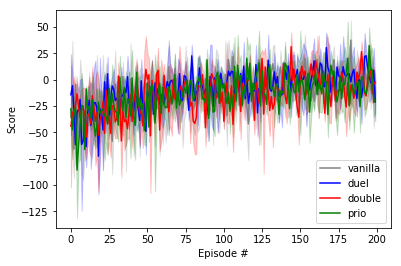

In [4]:
from models.dqn_agent import DQNAgent
from training.q_learning import dqn

vanilla = DQNAgent(state_size, action_size, seed, network_type='linear', config='single')
duel = DQNAgent(state_size, action_size, seed, network_type='duel', config='single')
double = DQNAgent(state_size, action_size, seed, network_type='linear', config='double')
prio = DQNAgent(state_size, action_size, seed, network_type='linear', config='single', memory_type='prioritized')

n_episodes = 200
max_t = 50
n_training_sessions = 3

scores_vanilla_x, scores_vanilla_mean, scores_vanilla_std = training_sessions(vanilla, env, n_episodes, max_t, n_training_sessions)
scores_duel_x, scores_duel_mean, scores_duel_std = training_sessions(duel, env, n_episodes, max_t, n_training_sessions)
scores_double_x, scores_double_mean, scores_double_std = training_sessions(double, env, n_episodes, max_t, n_training_sessions)
scores_prio_x, scores_prio_mean, scores_prio_std = training_sessions(prio, env, n_episodes, max_t, n_training_sessions)

fig = plt.figure()
ax = fig.add_subplot(111)

plot_multiple_sessions(scores_vanilla_x, scores_vanilla_mean, scores_vanilla_std, label=get_var_name(vanilla), color='gray')
plot_multiple_sessions(scores_duel_x, scores_duel_mean, scores_duel_std, label=get_var_name(duel), color='blue')
plot_multiple_sessions(scores_double_x, scores_double_mean, scores_double_std, label=get_var_name(double), color='red')
plot_multiple_sessions(scores_prio_x, scores_prio_mean, scores_prio_std, label=get_var_name(prio), color='green')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## 2. Train in Unity environment

### 1. Load the Unity environment and Take Random Actions in the Environment

Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
from unityagents import UnityEnvironment
from models.dqn_agent import DQNAgent

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86")
#env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

train_mode = False
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
state = env_info.vector_observations[0]
state_size = len(state)

state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
for t in range(10):
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
env.close()


ERROR:root:Exception calling application: could not find MARK
Traceback (most recent call last):
  File "/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/q392358/.local/share/virtualenvs/safe_gan/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 26, in Exchange
    return self.child_conn.recv()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
_pickle.UnpicklingError: could not find MARK


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

The observations are in a 37-dimensional continuous space corresponding to 35 dimensions of ray-based perception of objects around the agent’s forward direction and 2 dimensions of velocity. The 35 dimensions of ray perception are broken down as: 7 rays projecting from the agent at the following angles (and returned back in the same order): [20, 90, 160, 45, 135, 70, 110] where 90 is directly in front of the agent. Each ray is 5 dimensional and it projected onto the scene. If it encounters one of four detectable objects (i.e. yellow banana, wall, blue banana, agent), the value at that position in the array is set to 1. Finally there is a distance measure which is a fraction of the ray length. Each ray is [Yellow Banana, Wall, Blue Banana, Agent, Distance]. For example, [0,1,1,0,0,0.2] means that there is a blue banana detected 20% of the distance along the ray with a wall behind it. The velocity of the agent is two dimensional: left/right velocity (usually near 0) and forward/backward velocity (0 to 11.2).

### 3. Train

Unity has a different interface than OpenAI Gym, so we need to modify the episonde generation and training session methods. 

In [3]:
from training.q_learning import dqn_unity
def training_sessions_unity(agent, env, brain_name, env_info, n_episodes, max_t, n_training_sessions):
    scores_list = []
    for session in range(n_training_sessions):
        scores = np.asarray(dqn_unity(agent, env, brain_name, env_info, n_episodes, max_t))
        scores_list.append(scores)

    scores_list = np.asarray(scores_list)
    scores_x = np.arange(scores_list.shape[1])
    scores_mean = scores_list.mean(0)
    scores_std = scores_list.std(0)
    return scores_x, scores_mean, scores_std

Build the environment

In [4]:
from unityagents import UnityEnvironment
from models.dqn_agent import DQNAgent

env = UnityEnvironment(file_name="Banana_Linux/Banana.x86")
seed=0
#env = UnityEnvironment(file_name="Banana.app")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

train_mode = True
action_size = brain.vector_action_space_size
env_info = env.reset(train_mode=train_mode)[brain_name] # reset the environment
state = env_info.vector_observations[0]
state_size = len(state)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
vanilla = DQNAgent(state_size, action_size, seed, network_type='linear', config='single')
duel = DQNAgent(state_size, action_size, seed, network_type='duel', config='single')
double = DQNAgent(state_size, action_size, seed, network_type='linear', config='double')
prio = DQNAgent(state_size, action_size, seed, network_type='linear', config='single', memory_type='prioritized')
double_prio = DQNAgent(state_size, action_size, seed, network_type='linear', config='double', memory_type='prioritized')


In [ ]:
n_episodes = 2000
max_t = 1000
n_training_sessions = 1

scores_vanilla_x, scores_vanilla_mean, scores_vanilla_std = training_sessions_unity(vanilla, env, brain_name, env_info, n_episodes, max_t, n_training_sessions)
scores_duel_x, scores_duel_mean, scores_duel_std = training_sessions_unity(duel, env, brain_name, env_info, n_episodes, max_t, n_training_sessions)
scores_double_x, scores_double_mean, scores_double_std = training_sessions_unity(double, env, brain_name, env_info, n_episodes, max_t, n_training_sessions)
scores_prio_x, scores_prio_mean, scores_prio_std = training_sessions_unity(prio, env, n_episodes, max_t, n_training_sessions)
scores_double_prio_x, scores_double_prio_mean, scores_double_prio_std = training_sessions_unity(double_prio, env, brain_name, env_info, get_var_name(double_prio), n_episodes, max_t, n_training_sessions)


The unity environment via this notebooks is slow, so the code was executed in a shell (script: train_unity.py) and  the results were saved.

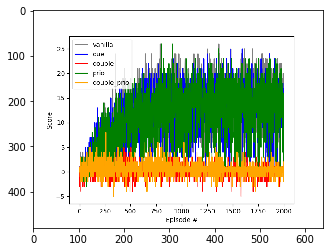

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('benchmark_unity_environment.png')
imgplot = plt.imshow(img)
plt.show()

## 3. Future work

What we see is that no variant of the vanilla DQN algorithm has higher rewards. We can do a few extra things to improve the performance:
- `1` - Train longer: Increase the number of episodes and maximum time steps per episode.
- `2` - Hyper parameter search.
- `3` - Alternative mdoel: DQN is known for bias, so an alternative model would be the DDPG algorithm.